In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, lfilter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.fft import fft
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

# Set seed untuk reproduktifitas
np.random.seed(42)

# Parameter dataset
n_samples_per_class = 100  # Jumlah sampel per kelas
time = np.linspace(0, 1, 500)  # 1 detik, 500 titik waktu (sampling rate 500 Hz)

# Definisi chord dan frekuensinya
chords = {
    'C': [261.63, 329.63, 392.00],    # C Major
    'G': [392.00, 493.88, 587.33],    # G Major
    'Am': [440.00, 261.63, 329.63],   # A Minor
    'Em': [329.63, 392.00, 493.88]    # E Minor
}

# Fungsi untuk menghasilkan sinyal chord
def generate_chord_signal(frequencies, time, noise_level=0.3):
    signal = np.zeros_like(time)
    for freq in frequencies:
        signal += np.sin(2 * np.pi * freq * time)
    # Tambahkan noise Gaussian
    signal += noise_level * np.random.normal(size=time.shape)
    return signal

# Membuat dataset
X = []
y = []

for chord_label, freqs in chords.items():
    for _ in range(n_samples_per_class):
        sig = generate_chord_signal(freqs, time)
        X.append(sig)
        y.append(chord_label)

X = np.array(X)
y = np.array(y)

print(f"Jumlah total sampel: {X.shape[0]}")
print(f"Jumlah fitur per sampel: {X.shape[1]}")


Jumlah total sampel: 400
Jumlah fitur per sampel: 500


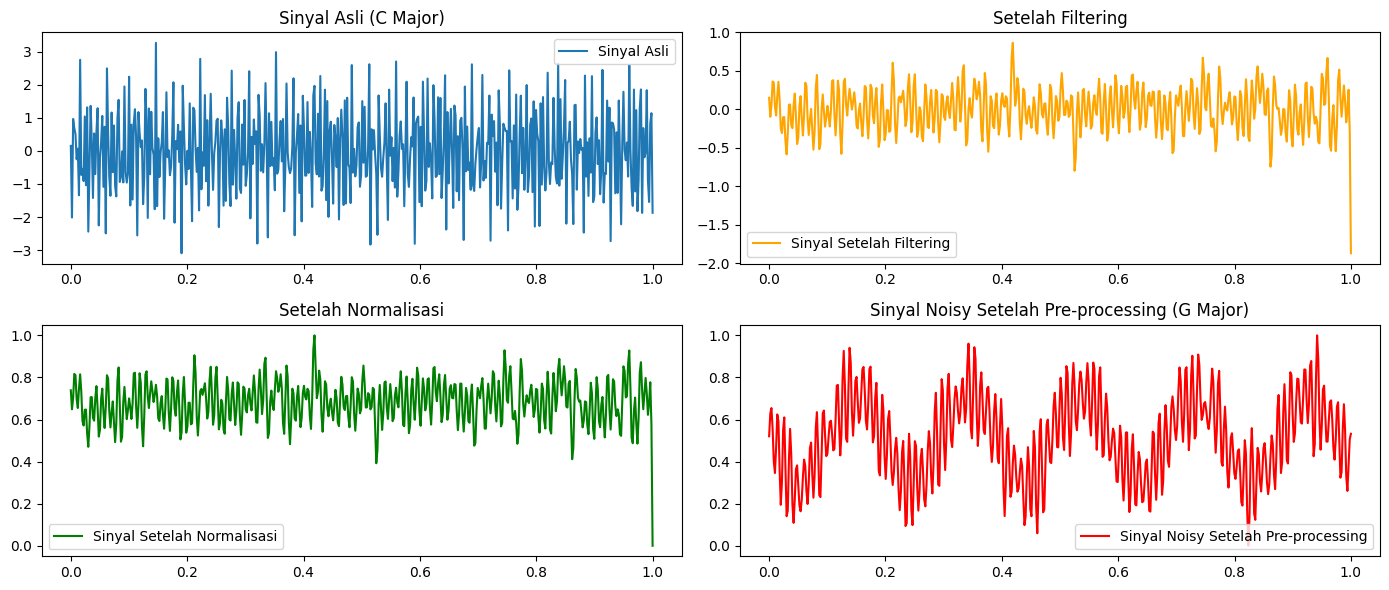

In [7]:
# Fungsi untuk melakukan filtering menggunakan Butterworth filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Frekuensi Nyquist
    normal_cutoff = cutoff / nyq
    # Desain filter Butterworth low-pass
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Definisikan frekuensi sampling dan frekuensi kritis
fs = 1000  # Frekuensi sampling (Hz)
cutoff = 200  # Frekuensi cutoff (Hz)

# Fungsi pre-processing
def preprocess_signal(signal):
    # 1. Filtering: Menggunakan low-pass filter untuk mengurangi noise frekuensi tinggi
    filtered = butter_lowpass_filter(signal, cutoff, fs)
    
    # 2. Normalisasi: Menstandarkan sinyal ke rentang 0-1
    normalized = (filtered - np.min(filtered)) / (np.max(filtered) - np.min(filtered))
    
    return normalized

# Hitung frekuensi Nyquist
nyquist = 0.5 * fs

# Normalisasi frekuensi cutoff dengan frekuensi Nyquist
normalized_cutoff = cutoff / nyquist

# Desain low-pass filter Butterworth
b, a = butter(N=4, Wn=normalized_cutoff, btype='low')

# Terapkan filter pada sinyal dummy
data = np.random.randn(1000)  # Sinyal random sebagai contoh
filtered_data = lfilter(b, a, data)

# Terapkan pre-processing pada semua sinyal
X_preprocessed = np.array([preprocess_signal(sig) for sig in X])

# Visualisasi pre-processing pada contoh sinyal
plt.figure(figsize=(14, 6))

# Sinyal sebelum pre-processing
plt.subplot(2, 2, 1)
plt.plot(time, X[0], label='Sinyal Asli')
plt.title('Sinyal Asli (C Major)')
plt.legend()


# Sinyal setelah filtering
plt.subplot(2, 2, 2)
filtered_signal = butter_lowpass_filter(X[0], cutoff, fs)
plt.plot(time, filtered_signal, label='Sinyal Setelah Filtering', color='orange')
plt.title('Setelah Filtering')
plt.legend()

# Sinyal setelah normalisasi
plt.subplot(2, 2, 3)
normalized_signal = preprocess_signal(X[0])
plt.plot(time, normalized_signal, label='Sinyal Setelah Normalisasi', color='green')
plt.title('Setelah Normalisasi')
plt.legend()

# Sinyal dengan noise setelah pre-processing
plt.subplot(2, 2, 4)
plt.plot(time, X_preprocessed[n_samples_per_class], label='Sinyal Noisy Setelah Pre-processing', color='red')
plt.title('Sinyal Noisy Setelah Pre-processing (G Major)')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
# Fungsi ekstraksi fitur dari sinyal pre-processed
def extract_features(signal):
    features = []
    
    # ---- Fitur Domain Waktu ----
    mean = np.mean(signal)
    std = np.std(signal)
    peaks, _ = find_peaks(signal, height=0.5)  # Deteksi puncak dengan ambang tinggi 0.5
    num_peaks = len(peaks)
    peak_to_peak = np.ptp(signal)  # Peak-to-Peak Amplitude
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr_feature = autocorr[1:11].mean()  # Rata-rata autocorrelation pada lag 1-10
    
    features.extend([mean, std, num_peaks, peak_to_peak, autocorr_feature])
    
    # ---- Fitur Domain Frekuensi ----
    # Menghitung FFT dan spektrum frekuensi
    N = len(signal)
    yf = fft(signal)
    xf = np.fft.fftfreq(N, 1/fs)
    yf = np.abs(yf[:N//2])  # Spektrum positif
    xf = xf[:N//2]
    
    # Energi Spektral
    energy = np.sum(yf**2)
    
    # Dominant Frequency
    dominant_freq = xf[np.argmax(yf)]
    
    features.extend([energy, dominant_freq])
    
    # ---- Fitur Non-Linear ----
    # Entropy
    # Normalisasi spektrum frekuensi untuk menghitung entropy
    yf_normalized = yf / np.sum(yf)
    spectral_entropy = entropy(yf_normalized)
    
    features.append(spectral_entropy)
    
    return features

# Ekstrak fitur untuk semua sampel
X_features = np.array([extract_features(sig) for sig in X_preprocessed])

# Tampilkan nama fitur
feature_names = [
    'Mean',
    'Std',
    'Num_Peaks',
    'Peak_to_Peak',
    'Autocorr',
    'Spectral_Energy',
    'Dominant_Freq',
    'Spectral_Entropy'
]

# Tampilkan beberapa fitur
print("Contoh Fitur:")
for i in range(5):
    feat = ", ".join([f"{name}={value:.2f}" for name, value in zip(feature_names, X_features[i])])
    print(f"Sampel {i+1}: {feat}")


Contoh Fitur:
Sampel 1: Mean=0.68, Std=0.10, Num_Peaks=107.00, Peak_to_Peak=1.00, Autocorr=231.64, Spectral_Energy=118198.33, Dominant_Freq=0.00, Spectral_Entropy=3.41
Sampel 2: Mean=0.67, Std=0.14, Num_Peaks=107.00, Peak_to_Peak=1.00, Autocorr=221.72, Spectral_Energy=113995.98, Dominant_Freq=0.00, Spectral_Entropy=3.74
Sampel 3: Mean=0.60, Std=0.13, Num_Peaks=107.00, Peak_to_Peak=1.00, Autocorr=178.16, Spectral_Energy=92031.17, Dominant_Freq=0.00, Spectral_Entropy=3.74
Sampel 4: Mean=0.69, Std=0.11, Num_Peaks=106.00, Peak_to_Peak=1.00, Autocorr=235.55, Spectral_Energy=120426.70, Dominant_Freq=0.00, Spectral_Entropy=3.49
Sampel 5: Mean=0.66, Std=0.13, Num_Peaks=107.00, Peak_to_Peak=1.00, Autocorr=219.66, Spectral_Energy=112661.39, Dominant_Freq=0.00, Spectral_Entropy=3.60



Akurasi model KNN: 1.00


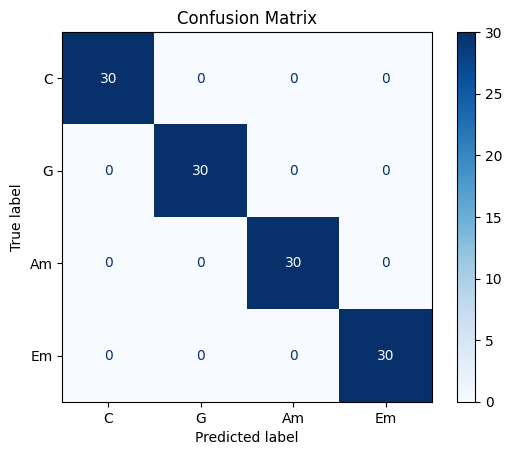

In [4]:
# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Membagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Inisialisasi dan melatih model KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Prediksi pada data test
y_pred = knn.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi model KNN: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=list(chords.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(chords.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()




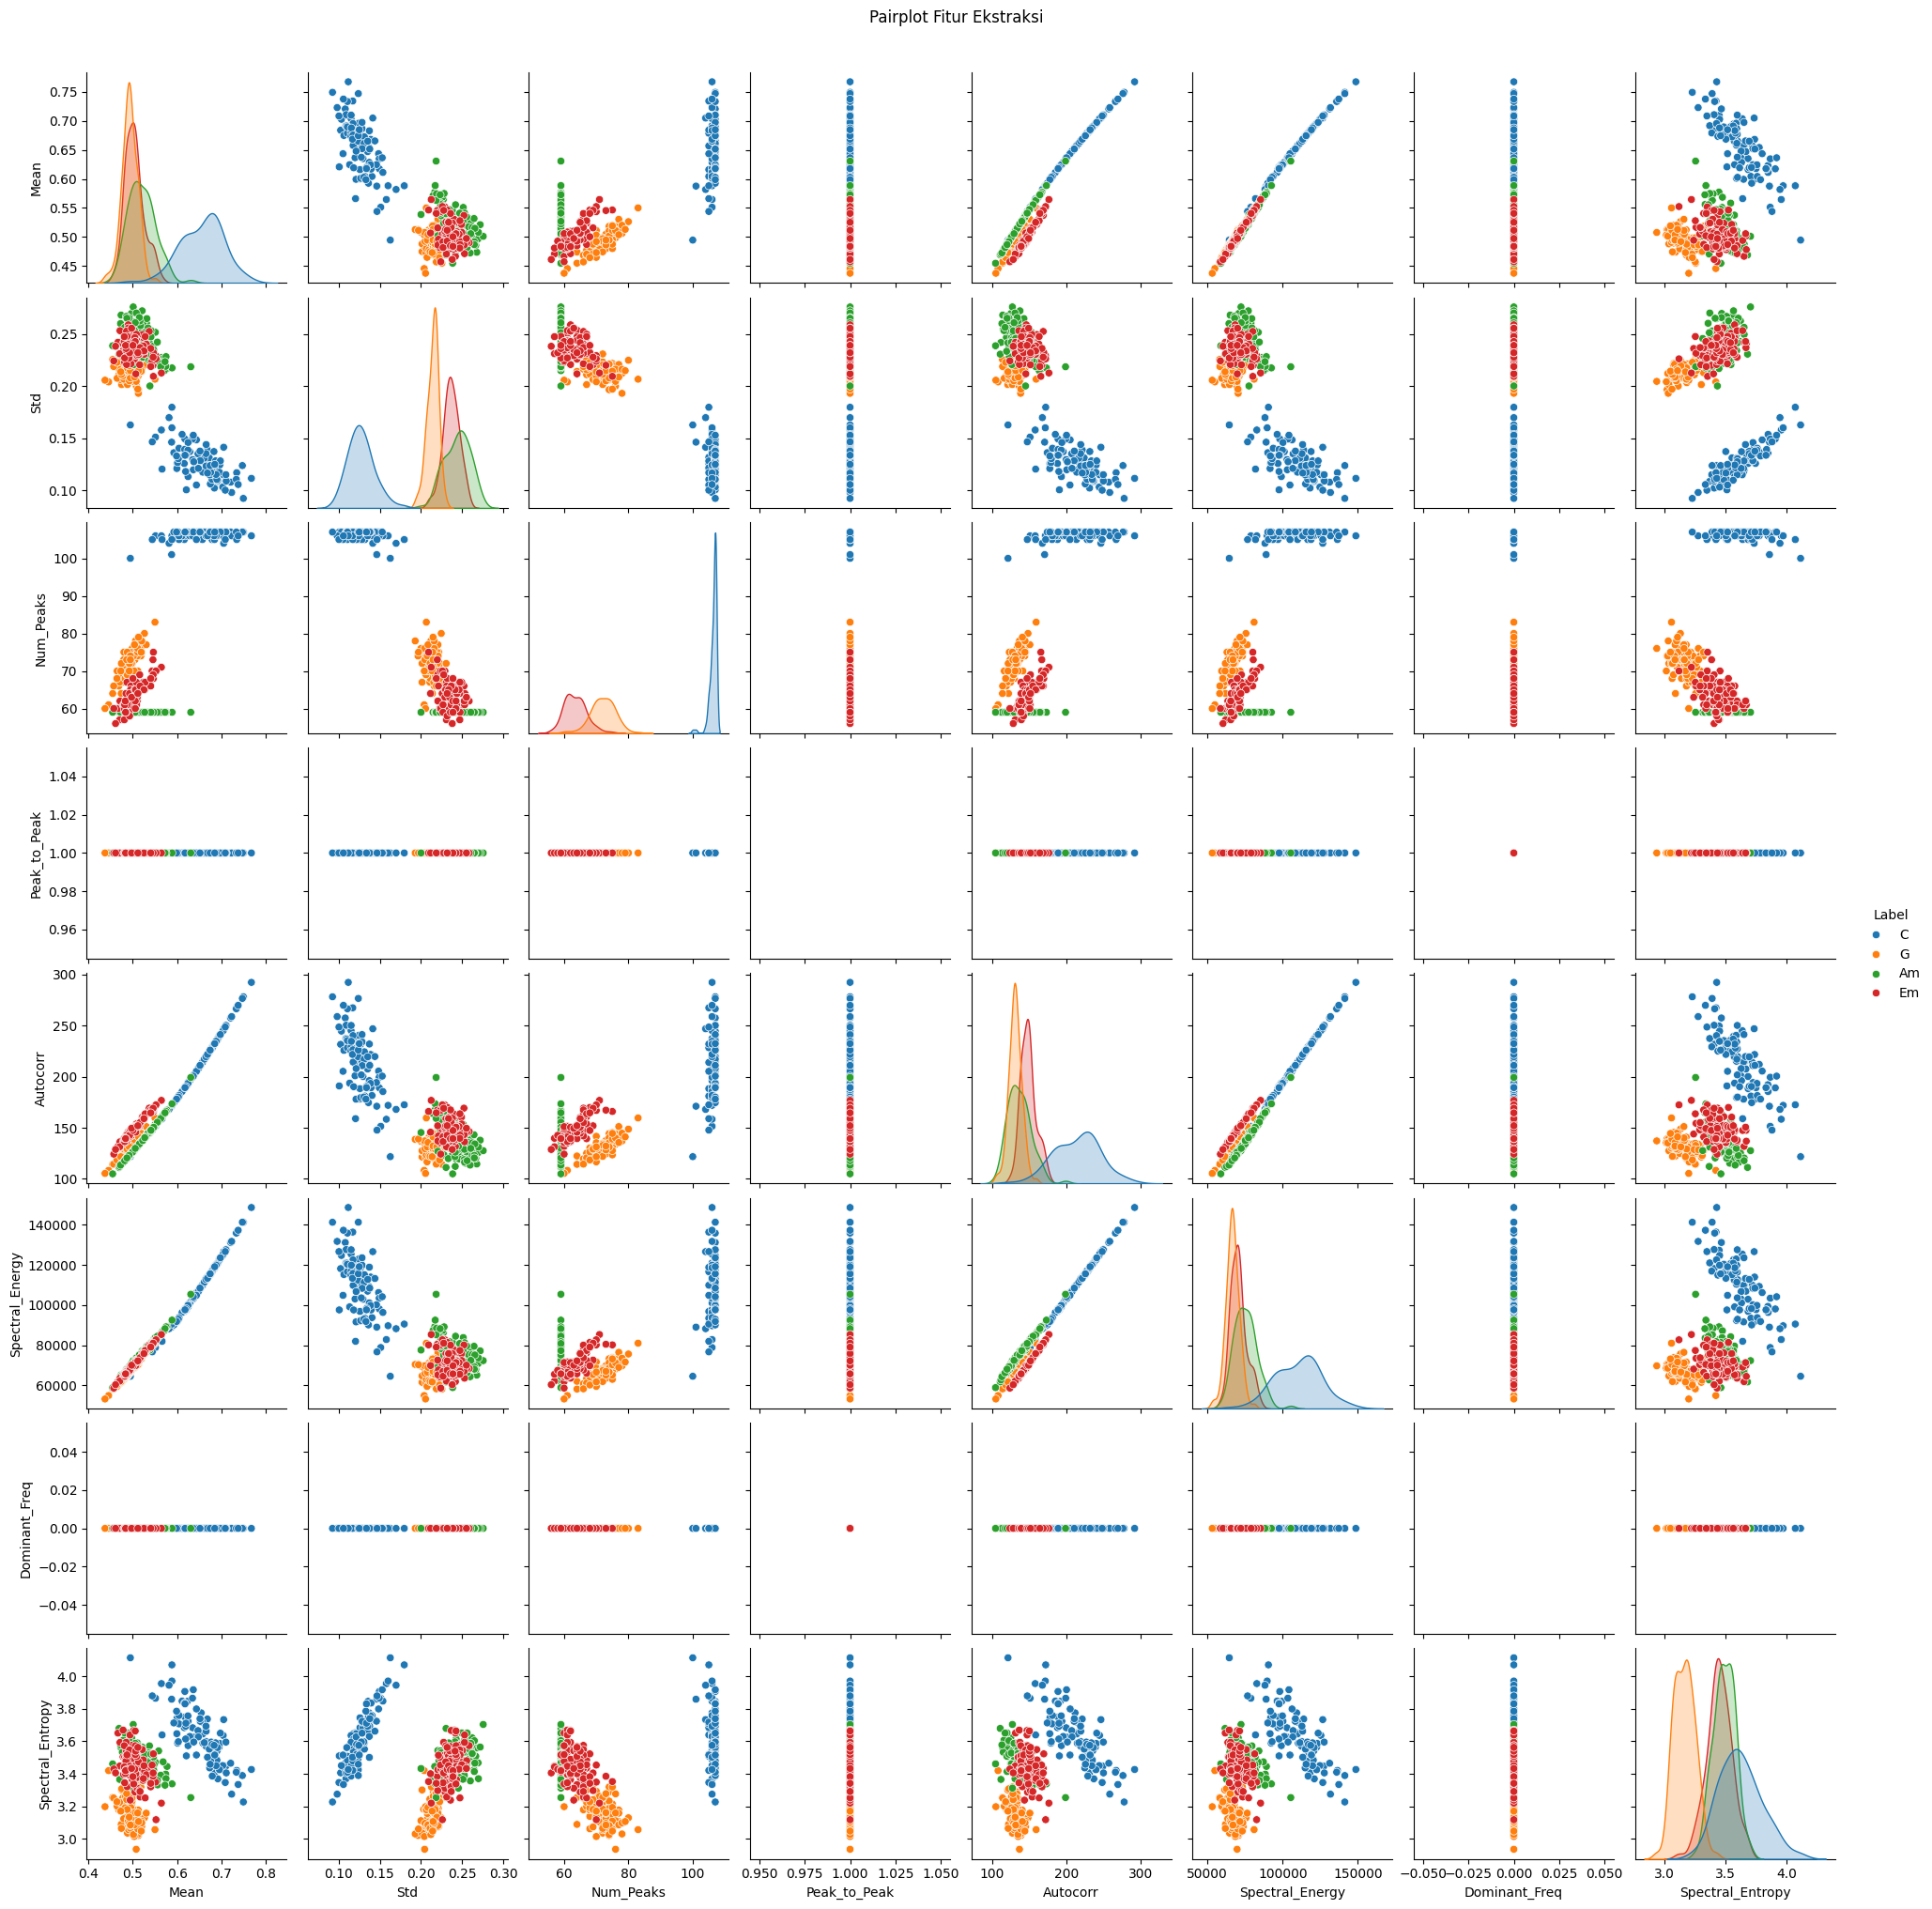

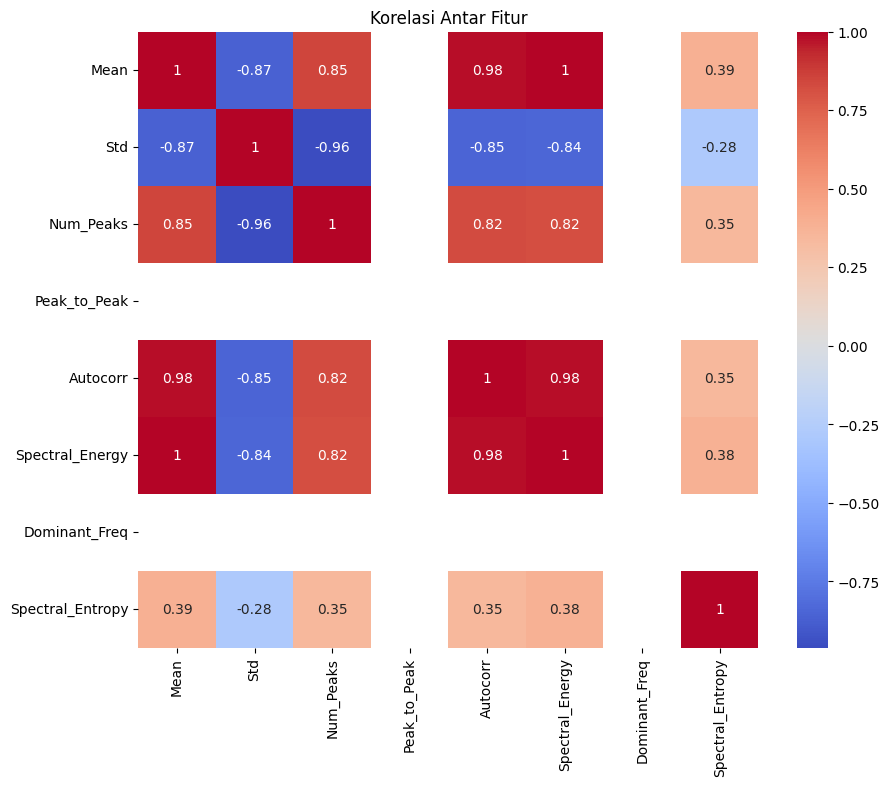

In [5]:
# Membuat DataFrame untuk visualisasi
df_features = pd.DataFrame(X_features, columns=feature_names)
df_features['Label'] = y

# Pairplot untuk melihat hubungan antar fitur
sns.pairplot(df_features, hue='Label', vars=feature_names)
plt.suptitle('Pairplot Fitur Ekstraksi', y=1.02)
plt.show()

# Heatmap untuk melihat korelasi antar fitur
plt.figure(figsize=(10, 8))
sns.heatmap(df_features[feature_names].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur')
plt.show()
